# Train syllable prediction model (without word boundaries)

This notebook experiments with syllable prediction from phonetics only. Word boundaries are not known, and must therefore be predicted as a regular syllable marker.

In [1]:
import regex as re

import numpy as np

from scipy.ndimage import gaussian_filter1d

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
# Dataset loader
def load_dataset(name):
    df = pd.read_csv(f"{name}.tsv", header=None, na_filter=False, encoding="utf-8")
    values = df.values[:, 0]
    return values

In [3]:
# Load dataset
train_values = load_dataset("train")
validation_values = load_dataset("validation")
test_values = load_dataset("test")

In [4]:
# IPA tokenization regex
IPA_R = re.compile(r"(.\u0303?\u02d0?)*")

# Tokenization helper
def tokenize(pronunciation):
    match = IPA_R.fullmatch(pronunciation)
    return match.captures(1)

In [5]:
# IPA vocabulary
IPA = [
    "<PAD>",
    "a", "b", "d", "e", "f", "i", "j",
    "k", "l", "m", "n", "o", "p", "s", "t",
    "u", "v", "w", "y", "z", "ø", "ŋ", "œ",
    "œ̃", "ɑ", "ɑ̃", "ɔ", "ɔ̃", "ə", "ɛ", "ɛ̃",
    "ɡ", "ɥ", "ɲ", "ʁ", "ʃ", "ʒ",
]
IPA_MAPPING = {p: i for i, p in enumerate(IPA)}

In [6]:
# Encode sample
def encode(value):
    phonemes = []
    labels = []
    for p in tokenize(value):
        l = 0

        # Dot and space are syllable markers
        if p == "." or p == " ":
            labels[-1] = 1
            continue

        # Liaison are stripped
        if p == "‿":
            continue

        # Append character
        phonemes.append(IPA_MAPPING[p])
        labels.append(l)

    # Pack as tensor
    phonemes = torch.tensor(phonemes, dtype=torch.uint8)
    labels = torch.tensor(labels, dtype=torch.uint8)
    return phonemes, labels

# Encode dataset
def encode_all(values):
    n = len(values)
    phonemes = np.empty(n, dtype=object)
    labels = np.empty(n, dtype=object)
    for i in range(n):
        phonemes[i], labels[i] = encode(values[i])
    return phonemes, labels

In [7]:
# Encode datasets
train_phonemes, train_labels = encode_all(train_values)
validation_phonemes, validation_labels = encode_all(validation_values)

In [8]:
# Pack multiple samples as a batch, with lengths
def pack_indices(phonemes, labels, max_length=None):
    n = len(phonemes)
    length = max(len(p) for p in phonemes)
    if max_length is not None and length > max_length:
        length = max_length
    phonemes_tensor = torch.zeros((length, n), dtype=torch.long)
    labels_tensor = torch.zeros((length, n), dtype=torch.long)
    lengths = torch.zeros(n, dtype=torch.long)
    for i in range(n):
        l = len(phonemes[i])
        l = min(l, length)
        for j in range(l):
            phonemes_tensor[j, i] = phonemes[i][j]
            labels_tensor[j, i] = labels[i][j]
        lengths[i] = l
    return phonemes_tensor, labels_tensor, lengths

In [9]:
# Define model
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.num_symbol = len(IPA)
        self.embedding_size = 16
        self.hidden_size = 32
        
        # Embed characters
        self.embedding = nn.Embedding(
            num_embeddings=self.num_symbol,
            embedding_dim=self.embedding_size,
            padding_idx=0,
        )
        
        # Use a single GRU
        self.gru = nn.GRU(
            input_size=self.embedding_size,
            hidden_size=self.hidden_size,
            num_layers=1,
            dropout=0,
            bidirectional=True,
        )
        
        # Use simple classifier
        self.classifier = nn.Linear(self.hidden_size * 2, 1)
    
    def _encode(self, phonemes, lengths):
        embeddings = self.embedding(phonemes)
        packed_embeddings = nn.utils.rnn.pack_padded_sequence(embeddings, lengths, enforce_sorted=False)
        packed_encodings, _ = self.gru(packed_embeddings)
        encodings, _ = nn.utils.rnn.pad_packed_sequence(packed_encodings)
        logits = self.classifier(encodings)
        return logits
    
    def forward(self, phonemes, labels, lengths):
        logits = self._encode(phonemes, lengths)
        l = labels.to(torch.float32)
        losses = F.binary_cross_entropy_with_logits(logits[:, :, 0], l, reduction="none")
        mask = (phonemes[:-1] > 0) & (phonemes[1:] > 0)
        loss = torch.sum(losses[:-1] * mask)
        return loss

In [10]:
# Create model
model = Model()

# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [11]:
indices = np.arange(len(train_phonemes))

batch_size = 32
max_length = 64

n_batches = (len(indices) - 1) // batch_size + 1

losses = []

for epoch in range(1):
    np.random.shuffle(indices)

    with tqdm(range(n_batches)) as progress:
        for batch in progress:

            optimizer.zero_grad()

            idx = indices[batch*batch_size:(batch+1)*batch_size]
            batch_phonemes, batch_labels, batch_lengths = pack_indices(train_phonemes[idx], train_labels[idx], max_length)

            loss = model(batch_phonemes, batch_labels, batch_lengths)

            loss.backward()
            optimizer.step()

            loss = float(loss.detach())
            losses.append(loss)
            progress.set_description(f"{loss:.03f}")

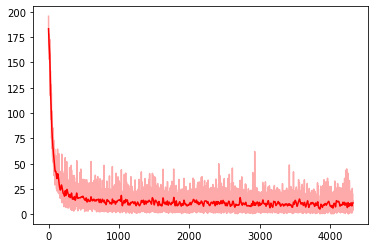

In [12]:
fig, ax = plt.subplots()

y = np.array(losses)
x = np.arange(y.shape[0])
y_smooth = gaussian_filter1d(y, 5, mode="nearest")

ax.plot(x, y, c="#ffaaaa")
ax.plot(x, y_smooth, "r")

plt.show()

In [13]:
# Save model
torch.save(model.state_dict(), "model.nospace.pt")

In [14]:
# Import model for inference
model = Model()
model.load_state_dict(torch.load("model.nospace.pt"))
model.eval()

Model(
  (embedding): Embedding(38, 16, padding_idx=0)
  (gru): GRU(16, 32, bidirectional=True)
  (classifier): Linear(in_features=64, out_features=1, bias=True)
)

## Apply model

In [15]:
def infer_syllable(pronunciation):
    
    # Encode
    phonemes, labels = encode_all([pronunciation])
    phonemes, labels, lengths = pack_indices(phonemes, labels)
    
    # Apply model
    logits = model._encode(phonemes, lengths)
    probabilities = torch.sigmoid(logits)
    
    # Compute application mask
    mask = torch.zeros_like(phonemes, dtype=torch.bool)
    mask[:-1] = (phonemes[:-1] > 0) & (phonemes[1:] > 0)
    
    # Compute actual probabilities
    probabilities = probabilities[:, :, 0] * mask
    
    # Threshold
    output = probabilities > 0.5
    
    # Reconstruct pronunciation
    parts = []
    for i in range(phonemes.shape[0]):
        parts.append(IPA[phonemes[i, 0]])
        if output[i, 0]:
            parts.append(".")
    syllable = "".join(parts)
    return syllable

In [16]:
# Manual example (from train set)
infer_syllable("vɛk.tœʁ a.le.a.twaʁ kɔ̃.ti.ny")

'vɛk.tœ.ʁa.le.a.twaʁ.kɔ̃.ti.ny'

In [17]:
# Apply on some element of the test set
n = len(test_values)
indices = torch.randperm(n)[:10]
for i in indices:
    truth = test_values[i]
    truth = truth.replace(" ", ".").replace("‿", "")
    prediction = infer_syllable(test_values[i])
    status = "OK" if truth == prediction else "NOPE"
    print(f"#{i}: {status}")
    print(f"  truth: {truth}")
    print(f"  pred.: {prediction}")

#12153: OK
  truth: stʁas.buʁ.ʒi.ze
  pred.: stʁas.buʁ.ʒi.ze
#25573: OK
  truth: e.bʁɥi.tas
  pred.: e.bʁɥi.tas
#44531: OK
  truth: mɔ.ʁa.li.ze
  pred.: mɔ.ʁa.li.ze
#25547: OK
  truth: ab.ka.zi
  pred.: ab.ka.zi
#45734: OK
  truth: ʁys.kɔf
  pred.: ʁys.kɔf
#68531: OK
  truth: e.ʁɔ.i.zə.ʁɛ
  pred.: e.ʁɔ.i.zə.ʁɛ
#26932: OK
  truth: syʁ.pje
  pred.: syʁ.pje
#10776: OK
  truth: ku.jɔ.nə.ʁɔ̃
  pred.: ku.jɔ.nə.ʁɔ̃
#42111: OK
  truth: ʒy.mɛ.li.zə.ʁe
  pred.: ʒy.mɛ.li.zə.ʁe
#3197: OK
  truth: me.mwaʁ.də.fɔʁm
  pred.: me.mwaʁ.də.fɔʁm


In [29]:
# Apply on some element of the test set
n = len(test_values)
ok = 0
for i in tqdm(range(n)):
    truth = test_values[i]
    truth = truth.replace(" ", ".").replace("‿", "")
    prediction = infer_syllable(test_values[i])
    if truth == prediction:
        ok += 1
print(f"sentence-level accuracy: {100.0 * ok / n:.2f}%")


sentence-level accuracy: 95.23%


## Evaluate

In [18]:
# Use test set
values = test_values

In [19]:
# Pack everything
phonemes, labels = encode_all(values)
phonemes, labels, lengths = pack_indices(phonemes, labels)

In [20]:
# Apply model, using batches
probabilities = torch.zeros_like(phonemes, dtype=torch.float32)
batch_size = 32
n_batches = (len(values) - 1) // batch_size + 1
with torch.no_grad():
    for b in tqdm(range(n_batches)):
        batch_phonemes = phonemes[:, b*batch_size:(b+1)*batch_size]
        batch_labels = labels[:, b*batch_size:(b+1)*batch_size]
        batch_lengths = lengths[b*batch_size:(b+1)*batch_size]

        # Apply model
        batch_logits = model._encode(batch_phonemes, batch_lengths)
        batch_probabilities = torch.sigmoid(batch_logits)

        # Compute application mask
        mask = torch.zeros_like(batch_phonemes, dtype=torch.bool)
        mask[:-1] = (batch_phonemes[:-1] > 0) & (batch_phonemes[1:] > 0)

        # Compute actual probabilities
        l = batch_probabilities.shape[0]
        probabilities[:l, b*batch_size:(b+1)*batch_size] = batch_probabilities[:, :, 0] * mask[:l]

In [21]:
truth = labels > 0
prediction = probabilities > 0.5
mask = phonemes > 0

tp = int((( truth &  prediction) & mask).sum())
fp = int(((~truth &  prediction) & mask).sum())
tn = int(((~truth & ~prediction) & mask).sum())
fn = int((( truth & ~prediction) & mask).sum())

accuracy = (tp + tn) / (tp + fp + tn + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"accuracy: {100*accuracy:.2f}%")
print(f"precision: {100*precision:.2f}%")
print(f"recall: {100*recall:.2f}%")

accuracy: 99.03%
precision: 98.52%
recall: 98.55%


In [22]:
# Compute character error rate
error_count = (truth != prediction).sum(axis=0)
length = mask.sum(axis=0)
character_error_rate = error_count.to(torch.float32) / length

In [23]:
def prediction_to_text(phonemes, prediction):
    characters = []
    for p, l in zip(phonemes, prediction):
        if p == 0:
            break
        characters.append(IPA[p])
        if l:
            characters.append(".")
    syllable = "".join(characters)
    return syllable


predictions = [prediction_to_text(phonemes[:, i], prediction[:, i]) for i in range(len(values))]

In [24]:
# Pack as data frame
out_df = pd.DataFrame({
    "truth": values,
    "prediction": predictions,
    "cer": character_error_rate,
})
out_df["truth"] = out_df["truth"].str.replace(" ", ".")
out_df["truth"] = out_df["truth"].str.replace("‿", "")

In [25]:
# Show all errors
with pd.option_context("display.max_rows", 9999):
    mistakes = out_df[out_df["cer"] > 0]
    display(mistakes.sort_values("cer", ascending=False))

truth  \
5406                                          ɛʁ.ə.ɛʁ.iz   
62021                                         ɛs.ɛm.ɛ.sɛ   
15001                                          ʃut.ɛm.œp   
23849                                        ɛm.ɛm.ɛ.sɑ̃   
20831                                         ɛm.ɛm.ɛ.sa   
9526                                    sə.ɛs.ɛm.ɛs.i.ze   
61585                                              ɔp.aʁ   
43978                                       ɛʁ.ə.ɛʁ.i.za   
20255                                        ɛs.ɛm.ɛ.sɛʁ   
4175                                        ɛs.ɛm.ɛ.sjɔ̃   
4095                                               ɛl.aʃ   
59146                                             ɛs.ə.o   
48716                                              il.ɔp   
34403                                              ɛf.ʁɛ   
57428                                             ɛ.stɛ̃   
73144                                             ɑ̃t.nɛ   
57556                                             a.ɛs.ə   
47277                                              œʁ.aʃ   
18332                                        ɛs.ɛm.ɛ.sas   
73196                                             a.vnɑ̃   
31497                                   lɑ̃.ɡaʒ.ɛs.ɛm.ɛs   
64221                                        ʒi.mnɔ.spɔʁ   
66167                                       ɛ̃.skʁi.ptœʁ   
66649                                     ɛs.ɛm.ɛ.sə.ʁɔ̃   
12737                                      ɛm.ɛm.ɛ.sə.ʁe   
52742                                     be.aʃ.ɛl.i.zɔ̃   
68041                                        ʒi.mnɔ.stil   
39226                                        maʁʒ.aʁ.jɛʁ   
54371                                       aʁd.ɛn.ɛʁ.ʒi   
67929                                       œʁt.lɑ̃d.ʁɔk   
4763                                      se.ɛs.ɛs.i.zɑ̃   
38840                                      ɛs.ɛm.ɛ.sə.ʁa   
58981                                koz.ʁe.ɛl.e.sɛʁ.jøz   
47271                                   y.ɛʁ.ɛl.ɑ̃.kɔ.da   
72994                                             ɔ.pnɛz   
42900                                             van.of   
35210                                            se.ɛl.ə   
3640                                             i.ɛʁ.ɛs   
7533                                              i.vlin   
72923                                             ʃɔ.mʁe   
47602                                             by.ksi   
43495                                             ʒak.ʁi   
33039                                             ɔ.skan   
69116                                            dik.jɛ̃   
30918                                    ʒe.ɛʁ.aʃ.ɑ̃.liɲ   
32871                                             ɡɔl.wɛ   
46670                                             ku.ʁta   
71416                                             kon.ɛl   
5955                                      buʃ.a.buʃ.e.ne   
45754                                   y.ɛʁ.ɛl.ɑ̃.kɔ.de   
4775                                      fɑ̃.tasm.at.ik   
45291                                      ø.dja.pnø.sti   
46986                                             si.vlɔ   
65606                                             ɛtʁ.ɔf   
67288                             kuʁ.ɑ̃.liɲ.u.vɛʁ.a.tus   
67156                                     e.ʃɛl.ɛm.ɛs.ka   
58214                                             a.stœʁ   
58247                                             ɡɑt.ʁi   
18249                                             ɛks.pi   
57687                                             bɔ.sko   
19190                                             pit.ʃe   
19222                                             bu.dʃu   
19420                                            ɛl.i.de   
58949                                            fɔʁ.y.e   
59155                                    sy.ʁɑ̃t.ʁɛn.mɑ̃   
20223                                             pik.ʁi   
56554                          

In [26]:
# Export TSV
out_df.to_csv("output.nospace.tsv", sep="\t", index=False, encoding="utf-8")